In [27]:
# Importing and initializing
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.cm as cm

node_df = pd.read_csv("2024_05_05_meta_node_data.csv")
edge_df = pd.read_csv("2024_04_24_meta_edge_sourcetarget_disease_pub_pli_reciprocal.csv")
geneGraph = nx.DiGraph()

/var/folders/6q/0qnxsny943385fwzz738241c0000gn/T/ipykernel_66033/1931457449.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  edge_df = pd.read_csv("2024_04_24_meta_edge_sourcetarget_disease_pub_pli_reciprocal.csv")


In [28]:
node_df.set_index('id',inplace=True)
node_df.head()

,symbol,disease_assoc_cat,publication_count,ortholog_count,all_ortho_count
id,,,,,
7414,VCL,disease_assoc,279,5,"{'hsapien': {'entrezid': 7414, 'symbol': 'VCL'..."
4626,MYH8,disease_assoc,36,4,"{'hsapien': {'entrezid': 4626, 'symbol': 'MYH8..."
9722,NOS1AP,disease_assoc,141,5,"{'hsapien': {'entrezid': 9722, 'symbol': 'NOS1..."
9891,NUAK1,non_disease_assoc,70,5,"{'hsapien': {'entrezid': 9891, 'symbol': 'NUAK..."
81788,NUAK2,disease_assoc,46,2,"{'hsapien': {'entrezid': 81788, 'symbol': 'NUA..."


In [29]:
# Constructing a directed graph with first edges
# This method would only work if you take the nodes in order because the index of edge_list and edge_df (and first_edges) must match
# Otherwise, the for loop would not work properly and the arrows would be wrong

# Take the first edges -- this is a list
first_edges = list(edge_df.iloc[:10000]['source_target_key'])

# Convert each edge into a tuple
edge_tuples = lambda x: tuple(map(int,x.split(';')))

# Put all those tuples in a list
edge_list = list(map(edge_tuples, first_edges))

# This is a list of all the edges reversed (it will be used in the for loop below)
reverse_edge_list = [(b,a) for (a,b) in edge_list]

# Adjusting the len(edge_list) to match the indicies of edge_list
edge_list_length = len(edge_list)
edge_list_length = edge_list_length - 1

# Finding if the 'reciprocal' value is True or False -- determines the direction of the edges
for index,edge in enumerate(edge_list):
    if index < edge_list_length:
        reciprocal = edge_df.iloc[index]['reciprocal']

        if reciprocal == True:
            reversed_edge = reverse_edge_list[index]
            edge_list.append(reversed_edge)
        else:
            pass
    else:
        pass


In [ ]:
# Sorting genes
# Creating a dict with their publication count
disease_assoc = {}
non_disease_assoc = {}
non_omim = {}
for index, row in node_df.iterrows():
    if row['disease_assoc_cat'] == 'disease_assoc':
        disease_assoc[index] = row['publication_count']
    elif row['disease_assoc_cat'] == 'non_disease_assoc':
        non_disease_assoc[index] = row['publication_count']
    elif row['disease_assoc_cat'] == 'non_omim':
        non_omim[index] = row['publication_count']

In [54]:
# Color spectrum based on publication count

# Identifying base colors for each category
base_colors = {'disease_assoc':'Reds', 'non_disease_assoc':'Blues', 'non_omim': 'Grays'}

# Mapping the categories to each other to normalize
all_nodes = {'disease_assoc': disease_assoc,'non_disease_assoc': non_disease_assoc, 'non_omim': non_omim}

# Storing node colors in a list
node_colors = []

# Map values to colors based on color map
def get_colors(nodes, cmap):
    values = list(nodes.values())
    norm = mcolors.Normalize(vmin=min(values), vmax=max(values))   # normalizing all values on a scale of 0 to 1 for coloring
    cmap = cm.get_cmap(cmap)
    return {node: cmap(norm(value)) for node, value in nodes.items()}

# Apply colormap to each category's nodes and collect colors
for category, nodes in all_nodes.items():
    cmap_name = base_colors[category]
    colors = get_colors(nodes, cmap_name)
    node_colors.extend(colors[node] for node in geneGraph.nodes if node in colors)




/var/folders/6q/0qnxsny943385fwzz738241c0000gn/T/ipykernel_66033/3286512571.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


In [51]:
# # Coloring nodes by disease_assoc_cat

# # Creating a dictionary that assigns nodes to their disease association in a dict
# nodes_list = list(geneGraph.nodes)

# disease_cat_dict = {}

# for node in nodes_list:
#     disease_assoc_cat = node_df.loc[node]['disease_assoc_cat']
#     if disease_assoc_cat == 'disease_assoc':
#         disease_cat_dict[node] = {'category':'disease_assoc'}
#     elif disease_assoc_cat == 'non_disease_assoc':
#         disease_cat_dict[node] = {'category':'non_disease_assoc'}
#     elif disease_assoc_cat == 'non_omim':
#         disease_cat_dict[node] = {'category':'non_omim'}
#     else:
#         print ('failed')

# # Assigning the attrubutes to the nodes
# nx.set_node_attributes(geneGraph, disease_cat_dict)

# # Creating a color map for the categories to colors
# node_color_map = {'disease_assoc':'tab:red', 'non_disease_assoc':'tab:blue','non_omim':'gray'}
# node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]

# # geneGraph.add_edges_from(edge_list)
# # pos = nx.spring_layout(geneGraph, k=0.7, iterations=15)
# # nx.draw(geneGraph, pos, with_labels=False, width = 0.7, node_color=node_colors, node_size=50, font_size = 10, font_color='black')
# # plt.figure(figsize=(100, 50))
# # plt.show()

In [33]:
# Coloring edges by 6 sections of interaction_type

# GPT's 6 sections of the 84 items
genetic_interactions = ['cisphenotypic genetic ','mutual genetic over-su','association', 'genetic interaction', 'genetic suppression', 'genetic suppression (p', 'genetic suppression (c', 'genetic enhancement', 'genetic epistasis (sen', 'phenotypic suppression', 'asynthetic genetic int', 'cisphenotypic co-suppr', 'opposing genetic epist', 'minimal genetic epista', 'synthetic growth defec', 'transphenotypic enhanc', 'transphenotypic geneti', 'genetic over-suppressi', 'negative genetic inter', 'positive genetic inter']
physical_interactions = ['self interaction','physical association', 'direct interaction', 'colocalization', 'proximity', 'protein cleavage', 'disulfide bond', 'Co-localization', 'Co-fractionation', 'Co-purification', 'Co-crystal Structure', 'Protein-peptide', 'Protein-RNA']
post_translational_modifications = ['demethylation reaction', 'phosphorylation reacti', 'acetylation reaction', 'covalent binding', 'cleavage reaction', 'dephosphorylation reac', 'ubiquitination reactio', 'methylation reaction', 'deacetylation', 'cleavage', 'dephosphorylation', 'methylation', 'ubiquitination', 'deformylation reaction']
experimental_methods = ['Affinity Capture-RNA', 'Affinity Capture-Weste', 'Affinity Capture-MS', 'Two-hybrid', 'Biochemical Activity', 'Reconstituted Complex', 'Negative Genetic', 'Positive Genetic', 'PCA', 'FRET', 'Proximity Label-MS', 'Far Western', 'Affinity Capture-Lumin']
synthetic_rescue_and_dosage_interactions = ['synthetic genetic inte', 'mutual genetic enhance', 'maximal genetic epista', 'synthetic rescue (sens', 'dosage rescue (sensu B', 'synthetic rescue (sens', 'synthetic lethality (s', 'synthetic haploinsuffi', 'dosage rescue (sensu b', 'dosage growth defect (', 'Synthetic Rescue', 'Synthetic Lethality', 'Dosage Lethality', 'Dosage Rescue',  'Dosage Growth Defect', 'Synthetic Growth Defec', 'Synthetic Haploinsuffi']
phenotypic_interactions = ['monophenotypic genetic', 'phenotypic enhancement', 'putative self interact', 'cisphenotypic inter-su', 'cisphenotypic inter-suppr', 'Phenotypic Suppression', 'Phenotypic Enhancement']

# Creating a dict that assigns each interaction_type to its respective section
interaction_section_dict = {}

for index, edge in enumerate(geneGraph.edges):
    interaction_type = edge_df.loc[index]['interaction_type']
    #print(interaction_type)
    if interaction_type in genetic_interactions:
        interaction_section_dict[edge] = {'category':'Genetic Interaction'}
    elif interaction_type in physical_interactions:
        interaction_section_dict[edge] = {'category':'Physical Interaction'}
    elif interaction_type in post_translational_modifications:
        interaction_section_dict[edge] = {'category':'Post Translational Modification'}
    elif interaction_type in experimental_methods:
        interaction_section_dict[edge] = {'category':'Experimental Method'}
    elif interaction_type in synthetic_rescue_and_dosage_interactions:
        interaction_section_dict[edge] = {'category':'Synthetic Rescue and Dosage Interaction'}
    elif interaction_type in phenotypic_interactions:
        interaction_section_dict[edge] = {'category':'Phenotypic Interaction'}
    else:
        print('failed')

# Assigning attributes to edge
nx.set_edge_attributes(geneGraph, interaction_section_dict)

# Creating a color map that maps each section to a color
edge_section_color_map = {'Genetic Interaction':'orange', 'Physical Interaction':'yellow', 'Post Translational Modification':'green','Experimental Method':'purple','Synthetic Rescue and Dosage Interaction':'pink','Phenotypic Interaction':'black'}
edge_colors_int_section = [edge_section_color_map[geneGraph.edges[edge]['category']] for edge in geneGraph.edges]


In [44]:
# Coloring  edges by 5 top interaction types

interaction_type_dict = {}
for index, edge in enumerate(geneGraph.edges):
    interaction_type = edge_df.loc[index]['interaction_type']
    if interaction_type == 'Negative Genetic':
        interaction_type_dict[edge] = {'category':'Negative Genetic'}
    elif interaction_type == 'physical association':
        interaction_type_dict[edge] = {'category':'physical association'}
    elif interaction_type == 'Affinity Capture-MS':
        interaction_type_dict[edge] = {'category':'Affinity Capture-MS'}
    elif interaction_type == 'direct interaction':
        interaction_type_dict[edge] = {'category':'direct interaction'}
    elif interaction_type == 'Positive Genetic':
        interaction_type_dict[edge] = {'category':'Positive Genetic'}
    else:
        interaction_type_dict[edge] = {'category':'other'}

# Assigning attributes to edge
nx.set_edge_attributes(geneGraph, interaction_type_dict)

# Creating a color map to map the interaction types to colors
edge_type_color_map = {'Negative Genetic':'orange','physical association':'yellow','Affinity Capture-MS':'green','direct interaction':'purple', 'Positive Genetic':'pink', 'other':'black'}
edge_colors_int_type = [edge_type_color_map[geneGraph.edges[edge]['category']]for edge in geneGraph.edges]

In [59]:
# Coloring edges by interaction_cat

# Creating a dictionary that assigns edges to their interaction_cat in a dict
interaction_cat_dict = {}
for index,edge in enumerate(geneGraph.edges):
    interaction_cat = edge_df.loc[index]['interaction_cat']
    if interaction_cat == 'physical':
        interaction_cat_dict[edge] = {'category':'physical'}
    elif interaction_cat == 'genetic':
        interaction_cat_dict[edge] = {'category':'genetic'}
    else:
        print('failed')

# Assigning attributes to edge
nx.set_edge_attributes(geneGraph, interaction_cat_dict)

# Creating a color map for the categories to colors
edge_cat_color_map = {'physical':'orange', 'genetic':'green'}
edge_colors_int_cat = [edge_cat_color_map[geneGraph.edges[edge]['category']] for edge in geneGraph.edges]


In [60]:
# Thickness of the edges correspond to interaction_count

# Creating a dictionary that assigns edges to their interaction_count in a dict
interaction_count_dict = {}
for index, edge in enumerate(geneGraph.edges):
    interaction_count = edge_df.iloc[index]['interaction_count']
    if interaction_count == 1:
        interaction_count_dict[edge] = {'count':1}
    elif interaction_count == 2:
        interaction_count_dict[edge] = {'count':2}
    elif interaction_count == 3:
        interaction_count_dict[edge] = {'count':3}
    elif interaction_count == 4:
        interaction_count_dict[edge] = {'count':4}
    elif interaction_count == 5:
        interaction_count_dict[edge] = {'count':5}
    elif interaction_count == 6:
        interaction_count_dict[edge] = {'count':6}
    else:
        print('failed')

# Assigning attributes to edge
nx.set_edge_attributes(geneGraph, interaction_count_dict)

# Creating a width map for the categories to colors
edge_width_map = {1:0.02,2:0.07,3:.12,4:.17,5:.22,6:.27}    #thinner
# edge_width_map = {1:0.2,2:0.7,3:1.2,4:1.7,5:2.2,6:2.7}    #thicker
edge_widths = [edge_width_map[geneGraph.edges[edge]['count']] for edge in geneGraph.edges]

print(len(edge_widths))
print(len(edge_colors_int_cat))
print(len(geneGraph.edges))
print(len(edge_list))

print(len(geneGraph.nodes))
print(len(node_colors))



12832
12832
12832
15775
2061
2061


In [ ]:
# # Relabeling nodes to gene names
# ids_to_genes = {}

# for node in nodes_list:
#     id_gene = node_df.loc[node]['symbol']
#     ids_to_genes[node] = id_gene

/var/folders/6q/0qnxsny943385fwzz738241c0000gn/T/ipykernel_66033/4274084460.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


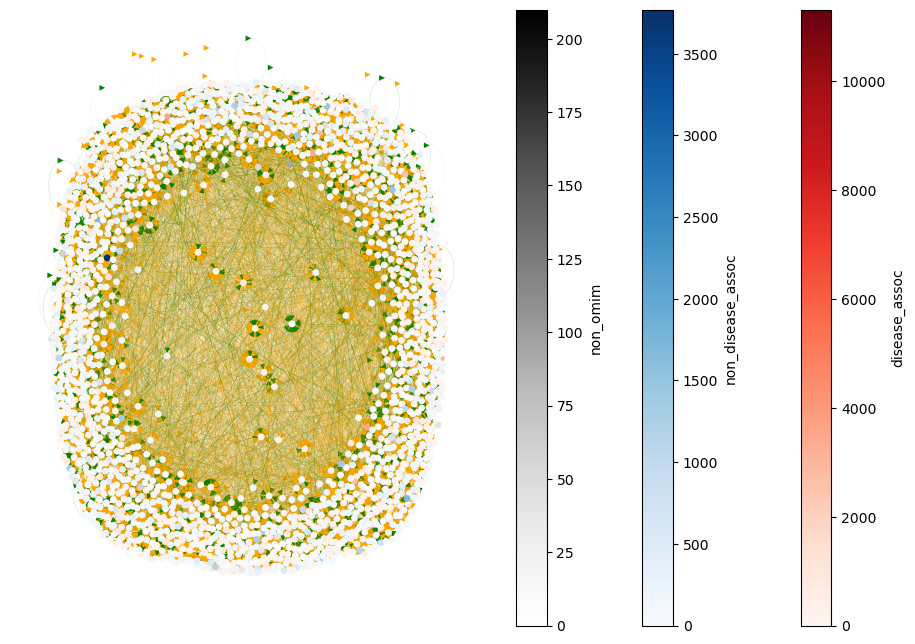

In [75]:
# Spring layout - colored by interaction_cat
geneGraph.add_edges_from(edge_list)
pos = nx.spring_layout(geneGraph, k=0.7, iterations=15, seed = 400) #scale
fig, ax = plt.subplots(figsize=(12, 8))
nx.draw(geneGraph, pos, with_labels=False, edge_color = edge_colors_int_cat, width = edge_widths, node_color=node_colors, node_size=15) #, font_size = 10, font_color='black')

# Showing the color bars
for category, nodes in all_nodes.items():
    cmap_name = base_colors[category]
    values = list(nodes.values())
    norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
    cmap = cm.get_cmap(cmap_name)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label=category)

plt.show()

In [ ]:
# #Spring layout - colored by 5 top interaction types
# node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
# geneGraph.add_edges_from(edge_list)
# pos = nx.spring_layout(geneGraph, k=0.7, iterations=15, seed = 400) #scale
# nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_type, node_color=node_colors, node_size=5) #, font_size = 10, font_color='black')
# plt.figure(figsize=(100, 50))
# plt.show()

In [ ]:
# # Spring layout - colored by 6 interaction type sections
# node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
# geneGraph.add_edges_from(edge_list)
# pos = nx.spring_layout(geneGraph, k=0.7, iterations=15, seed = 400) #scale
# nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_section, node_color=node_colors, node_size=5) #, font_size = 10, font_color='black')
# plt.figure(figsize=(100, 50))
# plt.show()

In [ ]:
# Spiral (equidistant)
node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
geneGraph.add_edges_from(edge_list)
pos = nx.spiral_layout(geneGraph, scale=1, center=None, dim=2, resolution=0.35, equidistant=True)
nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_cat, node_color=node_colors, node_size=5) #, font_size = 10, font_color='black')
plt.figure(figsize=(100, 50))
plt.show()

In [ ]:
# Spiral (sparkler)
node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
geneGraph.add_edges_from(edge_list)
pos = nx.spiral_layout(geneGraph, scale=1, center=None, dim=2, resolution=0.35, equidistant=False)
nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_cat, node_color=node_colors, node_size=20) #, font_size = 10, font_color='black')
plt.figure(figsize=(100, 50))
plt.show()

In [ ]:
# Circular
node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
geneGraph.add_edges_from(edge_list)
pos = nx.circular_layout(geneGraph, scale=1, center=None, dim=2)
nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_cat, node_color=node_colors, node_size=20) #, font_size = 10, font_color='black')
plt.figure(figsize=(100, 50))
plt.show()

In [ ]:
# Kamada Kawai
node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
geneGraph.add_edges_from(edge_list)
pos = nx.kamada_kawai_layout(geneGraph, dist=None, scale=1, center=None, dim=2)
nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_cat, node_color=node_colors, node_size=5) #, font_size = 10, font_color='black')
plt.figure(figsize=(100, 50))
plt.show()

In [ ]:
# Multipartite (color grouping)
node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
geneGraph.add_edges_from(edge_list)
pos = nx.multipartite_layout(geneGraph, subset_key='category', align='vertical', scale=1, center=None)
nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_cat, node_color=node_colors, node_size=15) #, font_size = 10, font_color='black')
plt.figure(figsize=(100, 50))
plt.show()

In [ ]:
# Spectral clustering
node_colors = [node_color_map[geneGraph.nodes[node]['category']] for node in geneGraph.nodes]
geneGraph.add_edges_from(edge_list)
pos = nx.spectral_layout(geneGraph, scale=1, center=None, dim=2)
nx.draw(geneGraph, pos, with_labels=False, width = edge_widths, edge_color = edge_colors_int_cat, node_color=node_colors, node_size=70) #, font_size = 10, font_color='black')
plt.figure(figsize=(100, 50))
plt.show()

In [ ]:
# ADJACENCY MATRIX

verticies = len(list(geneGraph.nodes()))
node_name_list = list(geneGraph.nodes())

# (Converting the elements from node_name_list from int to str)
node_list = []
for node in node_name_list:
    node = str(node)
    node_list.append(node)

# Mapping each node to an index and index to a node
node_to_index = {node: index for index,node in enumerate(nodes_list)}
index_to_node = {index: node for index,node in enumerate(nodes_list)}


# Converting each node from its name to its index
edge_index_list = []
for node1, node2 in edge_list:
    node1_index = node_to_index[node1]
    node2_index = node_to_index[node2]
    edge_index_list.append((node1_index, node2_index))

# Making an empty matrix
adj_matrix = [[0] * verticies for __ in range(verticies)]

# Add values to the matrix
for node1, node2 in edge_index_list:
    adj_matrix[node1][node2] = 1       # Becuase this is a directed graph

# Printing labels for the matrix
print("\nMatrix with Labels:")
print(" " + " ".join(node_list))
print("  " + "-" * (4 * verticies - 1))

# Iterate through each row of the matrix
for i, row in enumerate(adj_matrix):
    # Print the label for the current row node
    print(f"{node_name_list[i]} | " + "   ".join(map(str, row)))

